# MPS techniques for Boson Sampling

In this notebook, we explain how to use the MPS (Matrix Product State) backend to simulate a linear circuit. MPS simulation is based on a type of tensor network simulation, which gives an approximation of the output states [[1]](#References) [[2]](#References). It does the computation on each component of the circuits one-by-one, and not on the whole unitary. The states are represented by tensors, which are then updated at each component. These tensors can be seen as a big set of matrices, and the approximation is done by choosing the dimension of these matrices, called the *bond dimension*. For this example, we simulate a simple boson sampling problem, with 6 modes and 3 photons [[3]](#References).

In [1]:
import perceval as pcvl
import matplotlib.pyplot as plt

## Definition of the circuit

Just like in the Boson Sampling notebook, we generate a Haar-random unitary and its decomposition in a circuit :

6  modes triangular Boson Sampler :


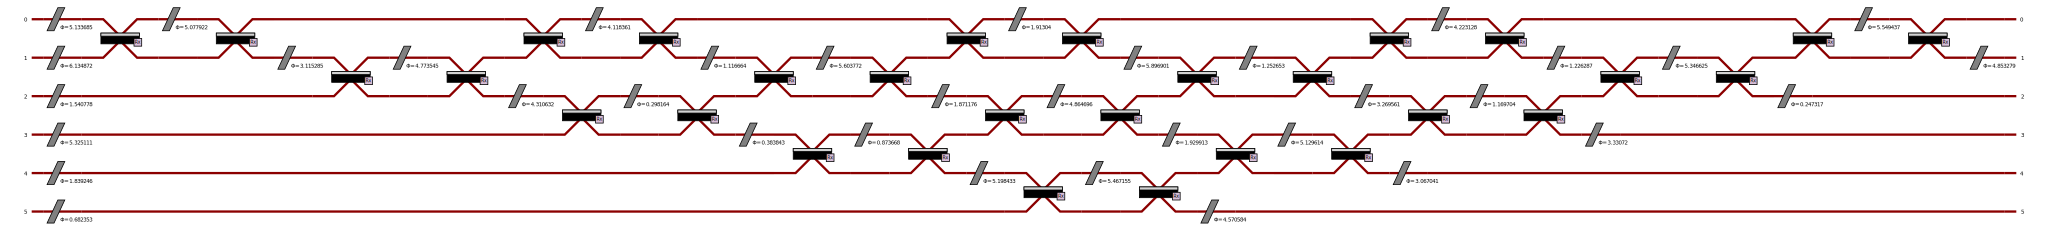

In [2]:
m = 6
unitary = pcvl.Matrix.random_unitary(m)
mzi = (pcvl.BS() // (0, pcvl.PS(phi=pcvl.Parameter("φ_a")))
       // pcvl.BS() // (1, pcvl.PS(phi=pcvl.Parameter("φ_b"))))
linear_circuit = pcvl.Circuit.decomposition(unitary, mzi,
                                               phase_shifter_fn=pcvl.PS,
                                               shape=pcvl.InterferometerShape.TRIANGLE)

print(m, " modes triangular Boson Sampler :")
pcvl.pdisplay(linear_circuit, compact = True)

## MPS simulation

Let us now define the MPS simulation, using the MPS backend in Perceval.

In [3]:
mps = pcvl.MPSBackend()
mps.set_circuit(linear_circuit)

We now choose the size of the matrices (the bond dimension) for our simulation.

In [4]:
chi = 8
mps.set_cutoff(chi)

And finally, we get the output probability distribution from a given input state with 3 photons.

In [5]:
n = 3
input_state = pcvl.BasicState([1]*n + [0]*(m-n))
mps.set_input_state(input_state)
probs = mps.prob_distribution()
pcvl.pdisplay(probs, max_v=20)

state,probability
"|0,0,0,0,1,2>",0.078508
"|0,0,0,0,0,3>",0.053524
"|2,1,0,0,0,0>",0.051962
"|0,0,0,0,2,1>",0.042042
"|3,0,0,0,0,0>",0.036251
"|0,0,1,1,0,1>",0.033647
"|1,0,1,0,1,0>",0.032665
"|1,1,0,0,0,1>",0.032312
"|1,2,0,0,0,0>",0.028953
"|2,0,0,0,1,0>",0.028039


## Certification of the MPS method :

As we make an approximation by choosing the bond dimension, we have to check when does this approximation becomes good enough. Unfortunately, there is no formula giving the minimal size for a given approximation error. What we can do though is to compute the *Total Variance Distance* (TVD) between an ideal simulation of Boson Sampling, and an approximated one. To compute the ideal one, we can for instance use the *SLOS* backend on Perceval :

In [6]:
slos = pcvl.SLOSBackend()
slos.set_circuit(pcvl.Unitary(unitary))
slos.set_input_state(input_state)
probs_slos = slos.prob_distribution()
pcvl.pdisplay(probs_slos, max_v=20)

state,probability
"|0,0,0,0,1,2>",0.078508
"|0,0,0,0,0,3>",0.053524
"|2,1,0,0,0,0>",0.051962
"|0,0,0,0,2,1>",0.042042
"|3,0,0,0,0,0>",0.036251
"|0,0,1,1,0,1>",0.033647
"|1,0,1,0,1,0>",0.032665
"|1,1,0,0,0,1>",0.032312
"|1,2,0,0,0,0>",0.028953
"|2,0,0,0,1,0>",0.028039


We also have to define the TVD function.

In [7]:
def tvd(probs1, probs2):
    tvd = 0
    for state, prob in probs1.items():
        tvd += abs(prob - probs2[state])
    return tvd


Now we compute the TVD between the two simulations for different bond dimensions, going from 1 to 10.

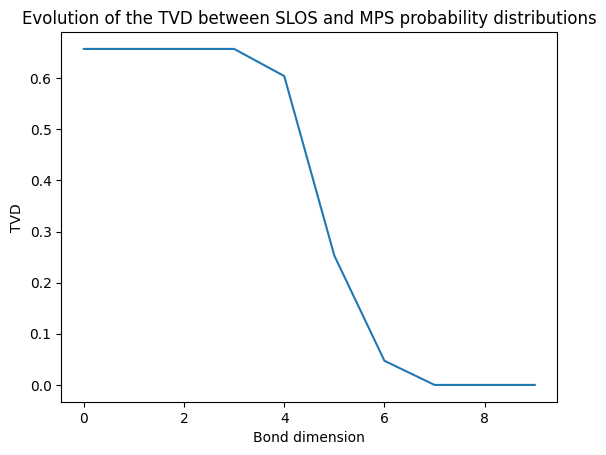

In [8]:
TVD = []
for chi in range(1,11):
    mps.set_cutoff(chi)
    mps.set_input_state(input_state)
    probs_mps = mps.prob_distribution()
    TVD.append(tvd(probs_mps, probs_slos))

plt.plot(TVD)
plt.xlabel('Bond dimension')
plt.ylabel('TVD')
plt.title('Evolution of the TVD between SLOS and MPS probability distributions');

We can see that the TVD decreases as the size of the matrices increases, until reaching 0 for a bond dimension of 7.

## References

> [1] Ulrich Schollwöck. The density-matrix renormalization group in the age of matrix product states. [Annals of Physics](https://doi.org/10.1016/j.aop.2010.09.012), 326(1):96–192, jan 2011.

> [2] Changhun Oh, Kyungjoo Noh, Bill Fefferman, and Liang Jiang. Classical simulation of lossy boson sampling using matrix product operators. [Physical Review A](https://doi.org/10.1103/PhysRevA.104.022407), 104(2), aug 2021.

> [3] Hui Wang, et al. Boson Sampling with 20 Input Photons and a 60-Mode Interferometer in a $10^{14}$-Dimensional Hilbert Space. [Physical Review Letters](https://link.aps.org/doi/10.1103/PhysRevLett.123.250503), 123(25):250503, December 2019. Publisher: American Physical Society.